Copyright (C) 2024  Adam Jones  All Rights Reserved

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import warnings

import figure_standard
import pandas as pd
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import os

In [2]:
figure_standard.standardize_plot_settings()
main_palette = figure_standard.create_main_palette()
study_palette = sns.color_palette("tab10", 10, desat=1)[5:]

# add a black for "all studies" to the start of the list
study_palette.insert(0, (0,0,0))

In [3]:
# get the meta results (including comparisons)
df_meta_results = pd.read_csv("../1_meta_analysis/meta_results_lci.csv")

In [4]:
# also, get the input so the weights can be calculated
# and the CIs can be plotted
df_meta_input = pd.read_excel("../1_meta_analysis/meta_input.xlsx")

# drop the excluded ones
df_meta_input.drop(df_meta_input[df_meta_input.exclude == 1.0].index, inplace=True)
df_meta_input.drop(df_meta_input[df_meta_input.paper == "Jones"].index, inplace=True)

# for null se values, where std is known, use that
use_std_indexes = df_meta_input[
    df_meta_input.se.isnull() & ~df_meta_input["std"].isnull()
].index
df_meta_input.loc[use_std_indexes, "se"] = df_meta_input.loc[use_std_indexes].apply(
    lambda x: x["std"] / math.sqrt(x["n"]), axis=1
)

# # for null se values, were CIs are known, use them
use_cis_indexes = df_meta_input[
    df_meta_input.se.isnull() & ~df_meta_input["lower_ci"].isnull()
].index
df_meta_input.loc[use_cis_indexes, "se"] = df_meta_input.loc[use_cis_indexes].apply(
    lambda x: (x["upper_ci"] - x["lower_ci"]) / 3.919928, axis=1
)

# # should be no more remaining unknown se values
assert df_meta_input.se.isnull().sum() == 0

# nor remaining null std values, calculate them using se
calc_std_indexes = df_meta_input[df_meta_input["std"].isnull()].index
df_meta_input.loc[calc_std_indexes, "std"] = df_meta_input.loc[calc_std_indexes].apply(
    lambda x: x["se"] * math.sqrt(x["n"]), axis=1
)

# should be no more remaining unknown std values
assert df_meta_input["std"].isnull().sum() == 0

# calculate missing CIs
calc_cis_indexes = df_meta_input[df_meta_input["lower_ci"].isnull()].index
df_meta_input.loc[calc_cis_indexes, "lower_ci"] = df_meta_input.loc[
    calc_cis_indexes
].apply(lambda x: x["kappa"] - x["se"] * 3.919928 / 2, axis=1)
df_meta_input.loc[calc_cis_indexes, "upper_ci"] = df_meta_input.loc[
    calc_cis_indexes
].apply(lambda x: x["kappa"] + x["se"] * 3.919928 / 2, axis=1)

In [5]:
stages = ["All", "Wake", "N1", "N2", "N3", "REM"]
studies = ["All", "CCSHS", "CFS", "CHAT", "MESA", "WSC"]

# reset the weights
df_meta_input["weight"] = 0

# now, using the tau2h value from the results, calculate the weights
for stage in stages:

    weight_indexes = df_meta_input.loc[df_meta_input.stage == stage].index

    # calculate the weight for each w=(se^2+tau^2)^-1
    w = (
        df_meta_input.loc[weight_indexes].se.values ** 2
        + df_meta_results.loc[df_meta_results.stage == stage].tau2h.values
    ) ** -1
    # normalize the weights so that the sum is 1
    w = w / w.sum()

    df_meta_input.loc[weight_indexes, "weight"] = w

In [6]:
# misc variables shared
sub_padding = 0.15
ci_linewidth = 0.5
text_size = 5
dy = 0.2
text_x = 0.13
diamond_dy_scale = 1.5
base_size = 20
main_linewidth = 0.5
meta_color = "black"
text_offset = -0.01
sig_offset = -0.05
preserved_fraction = 1
y_axis_pad = 0.5
grp_y_off = 0.45  # slightly less than y pad, so that it isn't clipped
grp_x_off = 0.05
grp_y_pad = 0.4
y_result_count = 1
use_diamonds_for_results = False
studies_width_ratio = 0.95
our_result_width_scale = 1.5


In [7]:
def plot_meta_and_our_results(overall: bool):

    if overall:
        ratios = [studies_width_ratio, 1]
        stages_to_plot = [stages[0]]
        palette_offset = 0
    else:
        ratios = [
            studies_width_ratio,
            1,
            sub_padding,
            1,
            sub_padding,
            1,
            sub_padding,
            1,
            sub_padding,
            1,
        ]
        stages_to_plot = stages[1:]
        palette_offset = 1

    gs = gridspec.GridSpec(1, len(ratios), width_ratios=ratios)

    ax = []
    ax_studies = plt.subplot(gs[0, 0])
    # ax += [plt.subplot(gs[0, 0])]
    # ax_studies = ax[0]  # easier reference name
    ax += [plt.subplot(gs[0, 1], sharey=ax_studies)]

    if not overall:
        ax += [plt.subplot(gs[0, 3], sharey=ax_studies)]
        ax += [plt.subplot(gs[0, 5], sharey=ax_studies)]
        ax += [plt.subplot(gs[0, 7], sharey=ax_studies)]
        ax += [plt.subplot(gs[0, 9], sharey=ax_studies)]

    sig_bar_x = [0] * len(ax)

    for j, stage in enumerate(stages_to_plot):
        print(stage)

        # only add the text once
        if j == 0:
            j_for_text = True
        else:
            j_for_text = False

        # get the meta indexes
        stage_indexes = list(df_meta_input[df_meta_input.stage == stage].index)

        max_y = len(stage_indexes) + 3 + (y_result_count - 1)

        scaled_weights = df_meta_input[df_meta_input.stage == stage].weight.values
        scaled_weights = scaled_weights / scaled_weights.max()
        assert scaled_weights.min() >= 0

        for i, meta_index in enumerate(stage_indexes):

            paper_name = (
                df_meta_input.loc[meta_index, "paper"]
                + ", "
                + str(df_meta_input.loc[meta_index, "year"])
            )
            if isinstance(df_meta_input.loc[meta_index, "group"], str):
                paper_name += " (" + df_meta_input.loc[meta_index, "group"] + ")"

            y = max_y - i
            lower_ci = float(df_meta_input.loc[meta_index, "lower_ci"])
            upper_ci = float(df_meta_input.loc[meta_index, "upper_ci"])
            mean_k = float(df_meta_input.loc[meta_index, "kappa"])

            sns.lineplot(
                x=[lower_ci, upper_ci],
                y=[y, y],
                color="black",
                linewidth=ci_linewidth,
                ax=ax[j],
            )

            ax[j].axvline(
                x=mean_k,
                ymin=(y - dy) / (max_y + y_axis_pad),
                ymax=(y + dy) / (max_y + y_axis_pad),
                color="black",
                linewidth=ci_linewidth,
                linestyle="-",
            )

            # s is an area
            sns.scatterplot(
                x=[mean_k],
                y=[y],
                color="black",
                s=base_size * scaled_weights[i],
                alpha=0.25,
                linewidth=0,
                ax=ax[j],
                marker="s",
            )
            if j_for_text:
                ax_studies.text(
                    text_x,
                    y / (max_y + y_axis_pad),
                    paper_name,
                    transform=ax_studies.transAxes,
                    color="black",
                    fontsize=text_size,
                    va="center",
                    ha="left",
                )

        # meta results
        y = 3 + (y_result_count - 1)
        mean_k = df_meta_results.loc[df_meta_results.stage == stage, "mean"].values[0]

        ax[j].axvline(
            x=mean_k,
            ymin=(y - dy * diamond_dy_scale) / (max_y + y_axis_pad),
            ymax=1,
            color=meta_color,
            linewidth=main_linewidth,
            linestyle="dotted",
        )

        lower_ci = df_meta_results.loc[df_meta_results.stage == stage, "lci"].values[0]
        upper_ci = df_meta_results.loc[df_meta_results.stage == stage, "uci"].values[0]

        sig_bar_x[j] = lower_ci * preserved_fraction

        x_array = [lower_ci, mean_k, upper_ci, mean_k, lower_ci]
        y_array = [y, y + dy * diamond_dy_scale, y, y - dy * diamond_dy_scale, y]
        sns.lineplot(
            x=x_array,
            y=y_array,
            color=meta_color,
            linewidth=ci_linewidth,
            estimator=None,
            sort=False,
            ax=ax[j],
        )

        lower_pi = df_meta_results.loc[df_meta_results.stage == stage, "lpi"].values[0]
        upper_pi = df_meta_results.loc[df_meta_results.stage == stage, "upi"].values[0]
        sns.lineplot(
            x=[lower_pi, lower_ci],
            y=[y, y],
            color=meta_color,
            linewidth=ci_linewidth,
            estimator=None,
            sort=False,
            ax=ax[j],
        )
        sns.lineplot(
            x=[upper_ci, upper_pi],
            y=[y, y],
            color=meta_color,
            linewidth=ci_linewidth,
            estimator=None,
            sort=False,
            ax=ax[j],
        )

        if preserved_fraction < 1:
            fill_x = [lower_ci * preserved_fraction, lower_ci, mean_k, upper_ci, 1]
            fill_y = [y, y, y - dy * diamond_dy_scale, y, y]
        else:
            fill_x = [lower_ci, mean_k, upper_ci, 1]
            fill_y = [y, y - dy * diamond_dy_scale, y, y]
        fill_y_l = [0] * len(fill_y)
        ax[j].fill_between(
            fill_x,
            fill_y,
            fill_y_l,
            color=main_palette[j + palette_offset],  # "black",
            alpha=0.1,
            edgecolor="none",
        )

        if j_for_text:
            ax_studies.text(
                text_x,
                y / (max_y + y_axis_pad),
                "Random-effects estimate",
                fontweight="bold",
                transform=ax_studies.transAxes,
                color=meta_color,
                fontsize=text_size,
                va="center",
                ha="left",
            )

        # our results
        start_y = 1 + (y_result_count - 1)
        for ii, study in enumerate(['All']):
            y = start_y - ii - 1 * (ii > 0)

            mean_k = df_meta_results.loc[
                df_meta_results.stage == stage, (study.lower() + "_mean")
            ].values[0]
            lower_ci = df_meta_results.loc[
                df_meta_results.stage == stage, (study.lower() + "_lci")
            ].values[0]
            upper_ci = df_meta_results.loc[
                df_meta_results.stage == stage, (study.lower() + "_uci")
            ].values[0]

            if (ii == 0) and (j == 3):
                sig_bar_x[3] = lower_ci

            x_array = [lower_ci, mean_k, upper_ci]
            y_array_upper = [y, y + dy * diamond_dy_scale, y]
            y_array_lower = [y, y - dy * diamond_dy_scale, y]

            if ii == 0:
                if use_diamonds_for_results:
                    sns.lineplot(
                        x=x_array,
                        y=y_array_upper,
                        color="black",
                        linewidth=ci_linewidth,
                        estimator=None,
                        sort=False,
                        ax=ax[j],
                    )
                    sns.lineplot(
                        x=x_array,
                        y=y_array_lower,
                        color="black",
                        linewidth=ci_linewidth,
                        estimator=None,
                        sort=False,
                        ax=ax[j],
                    )

            if use_diamonds_for_results:
                ax[j].fill_between(
                    x_array,
                    y_array_upper,
                    y_array_lower,
                    color=main_palette[j + palette_offset],
                    alpha=0.6,
                    edgecolor="none",
                )
            else:
                sns.lineplot(
                    x=[lower_ci, upper_ci],
                    y=[y, y],
                    color='black',
                    linewidth=ci_linewidth*our_result_width_scale,
                    ax=ax[j],
                )
                ax[j].axvline(
                    x=mean_k,
                    ymin=(y - dy) / (max_y + y_axis_pad),
                    ymax=(y + dy) / (max_y + y_axis_pad),
                    color='black',
                    linewidth=ci_linewidth*our_result_width_scale,
                    linestyle="-",
                )

            if j_for_text:
                if ii > 0:
                    x_padding = 0.2
                    study_label = study
                    fontweight = None
                    fontsize_adj = -0.5
                else:
                    x_padding = 0
                    study_label = "Our primary model"
                    fontweight = "bold"
                    fontsize_adj = 0

                ax_studies.text(
                    text_x + x_padding,
                    y / (max_y + y_axis_pad),
                    study_label,
                    fontweight=fontweight,
                    transform=ax_studies.transAxes,
                    fontsize=text_size + fontsize_adj,
                    color="black",
                    va="center",
                    ha="left",
                )
                

        # formatting stuff
        ax[j].set_ylim([0, max_y + y_axis_pad])
        ax[j].set_xlim([0, 1])

        ax[j].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

        # remove decimal points for first and last tick label
        labels = ax[j].get_xticklabels()
        labels[0] = str(0)
        labels[-1] = str(1)
        labels
        ax[j].set_xticklabels(labels)

        for label in ax[j].get_xticklabels()[1::2]:
            label.set_visible(False)

        for label in ax[j].get_yticklabels():
            label.set_visible(False)

        sns.despine(ax=ax[j], right=True, top=True, bottom=False)
        ax[j].grid(False)

        ax[j].tick_params(axis="x", bottom=True, width=1, length=3, pad=1)

        labelpad = 2.5
        ax[j].set_xlabel(
            "Cohen's kappa ($\kappa$)", fontweight=None, labelpad=labelpad, fontsize=6
        )

        title_fontsize = 7
        title_y = 1 + (1 / max_y)

        if stage == "All":
            stage_title = "Overall"
        else:
            stage_title = stage
        ax[j].text(
            0.5,
            title_y,
            stage_title,
            transform=ax[j].transAxes,
            color=main_palette[j + palette_offset],
            fontsize=title_fontsize,
            va="center",
            ha="center",
        )

    # studies label plot
    title_fontsize = 7

    outside_x = 0.05
    outside_size = 6

    # outside labels

    ## upper
    meta_lower_bound = y_result_count + 2
    meta_label_height = 7.5
    middle_meta_label_y = (max_y + meta_lower_bound) / 2
    # horizontal lines
    ax_studies.axhline(
        y=max_y + grp_y_off,
        xmin=outside_x,
        xmax=outside_x + grp_x_off,
        color="black",
        linewidth=0.5,
        linestyle="-",
    )
    ax_studies.axhline(
        y=(meta_lower_bound - grp_y_off),
        xmin=outside_x,
        xmax=outside_x + grp_x_off,
        color="black",
        linewidth=0.5,
        linestyle="-",
    )
    # vertical lines
    ax_studies.axvline(
        x=outside_x,
        ymin=((middle_meta_label_y + meta_label_height / 2) - grp_y_pad)
        / (max_y + y_axis_pad),
        ymax=(max_y + grp_y_off) / (max_y + y_axis_pad),
        color="black",
        linewidth=0.5,
        linestyle="-",
    )
    ax_studies.axvline(
        x=outside_x,
        ymin=(meta_lower_bound - grp_y_off) / (max_y + y_axis_pad),
        ymax=((middle_meta_label_y - meta_label_height / 2) + grp_y_pad)
        / (max_y + y_axis_pad),
        color="black",
        linewidth=0.5,
        linestyle="-",
    )
    # text
    ax_studies.text(
        outside_x,
        (middle_meta_label_y + 0.07) / (max_y + y_axis_pad),
        "meta-analysis",
        transform=ax_studies.transAxes,
        fontsize=outside_size,
        fontweight="bold",
        va="center",
        ha="center",
    ).set_rotation(90)


    ax_studies.grid(False)
    ax_studies.set_xlim([0, 1])

    sns.despine(ax=ax_studies, right=True, top=True, bottom=True, left=True)
    for label in ax_studies.get_xticklabels():
        label.set_visible(False)

    for label in ax_studies.get_yticklabels():
        label.set_visible(False)

    # necessary returns for other code
    return ax, max_y, sig_bar_x

In [8]:
def add_stat(
    axes,
    x_loc,
    top_y,
    bottom_y,
    stat_text,
    text_offset,
    x_offset=-0.02,
    star_offset=0.03,
):
    stat_color = "black"
    stat_width = 0.5

    axes.axhline(
        y=top_y,
        xmin=x_loc + x_offset,
        xmax=x_loc,
        color=stat_color,
        linewidth=stat_width,
        linestyle="-",
    )
    axes.axhline(
        y=bottom_y,
        xmin=x_loc + x_offset,
        xmax=x_loc,
        color=stat_color,
        linewidth=stat_width,
        linestyle="-",
    )
    axes.axvline(
        x=x_loc,
        ymin=bottom_y / (max_y + y_axis_pad),
        ymax=top_y / (max_y + y_axis_pad),
        color=stat_color,
        linewidth=stat_width,
        linestyle="-",
    )

    axes.text(
        x_loc + star_offset,
        (top_y / (max_y + y_axis_pad) + bottom_y / (max_y + y_axis_pad)) / 2
        + text_offset,
        stat_text,
        transform=axes.transAxes,
        fontsize=5,
        va="center",
        ha="left",
    )

All


1 extra bytes in post.stringData array
fdsc NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
just NOT subset; don't know how to subset; dropped


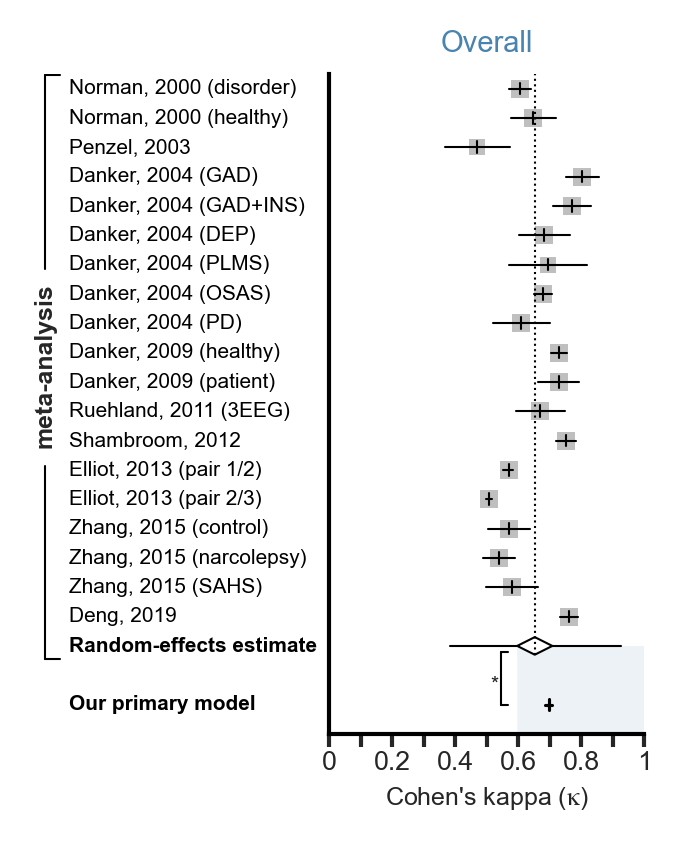

In [9]:
### Overall Plot

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)

    axes, max_y, sig_bar_x = plot_meta_and_our_results(True)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=0)
    figure_standard.scale_figure_by_axes(axes[0], 1.4 * max_y / 14, 1.05)

    y_high = 2.8
    ii = 0
    for i in [0]:
        if (i != 1) and (i != 6):
            ii += 1
            add_stat(
                axes[0], sig_bar_x[0] + sig_offset, i + 1, y_high, "*", text_offset, 0.02, -0.035
            )

# save the figure
filename = "figure_4"
figure_standard.save_figure_files(filename)

Wake
N1
N2
N3
REM


/tmp/ipykernel_1272673/2741968850.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
1 extra bytes in post.stringData array
fdsc NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
just NOT subset; don't know how to subset; dropped


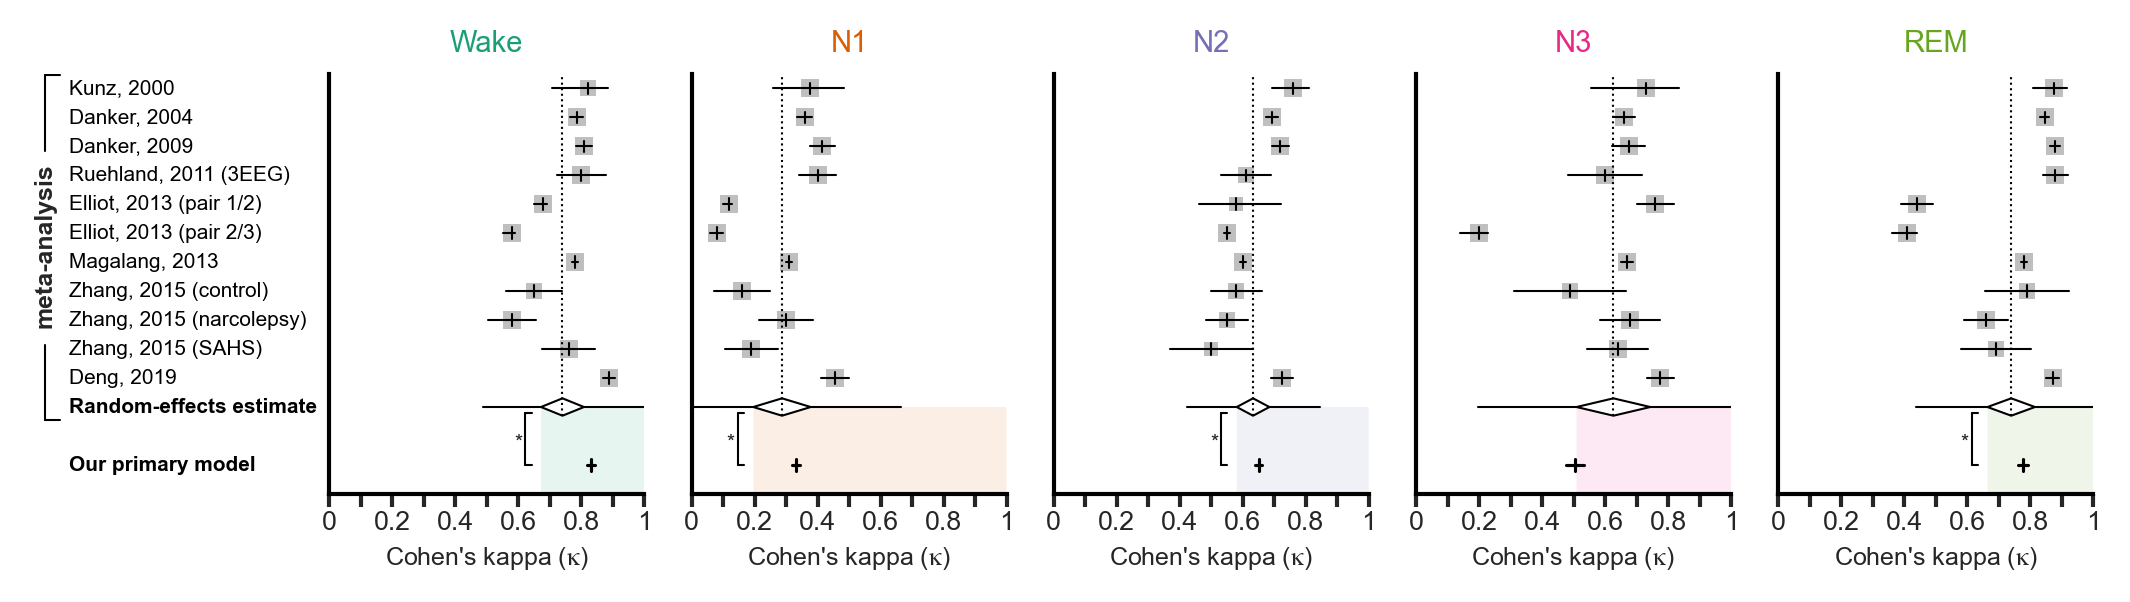

In [10]:
### Stage-wise Plot

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)

    axes, max_y, sig_bar_x = plot_meta_and_our_results(False)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=0)
    figure_standard.scale_figure_by_axes(axes[0], 1.4 * max_y / 14, 1.05)

    y_high = 2.8
    for j in range(5):
        ii = 0

        # # N3 only has a few bars
        if j == 3:
            pass

        # all others go from right
        else:
            for i in [0]:
                if i != 6:
                    ii += 1
                    add_stat(
                        axes[j],
                        sig_bar_x[j] + sig_offset,
                        i + 1,
                        y_high,
                        "*",
                        text_offset,
                        0.02,
                        -0.035,
                    )

# save the figure
filename = "figure_5"
figure_standard.save_figure_files(filename)

In [11]:
# source datasets breakdown

dx = 1/(8)
width_ratio = 0.4

def plot_meta_and_ours_transposed(axes, stage, offset):
    # plotting the results transposed (vertically, instead of horizontally)
    # and this function will plot just the necessary results


    ## meta result
    x = offset + dx
    mean_k = df_meta_results.loc[df_meta_results.stage == stage, "mean"].values[0]

    lower_ci = df_meta_results.loc[df_meta_results.stage == stage, "lci"].values[0]
    upper_ci = df_meta_results.loc[df_meta_results.stage == stage, "uci"].values[0]

    y_array = [lower_ci, mean_k, upper_ci, mean_k, lower_ci]
    x_array = [x, x + dx*width_ratio , x, x - dx*width_ratio , x]
    sns.lineplot(
        x=x_array,
        y=y_array,
        color=meta_color,
        linewidth=ci_linewidth,
        estimator=None,
        sort=False,
        ax=axes,
    )

    lower_pi = df_meta_results.loc[df_meta_results.stage == stage, "lpi"].values[0]
    upper_pi = df_meta_results.loc[df_meta_results.stage == stage, "upi"].values[0]
    axes.axvline(
        x=x,
        ymin=lower_pi,
        ymax=lower_ci,
        color=meta_color,
        linewidth=ci_linewidth,
    )
    axes.axvline(
        x=x,
        ymin=upper_ci,
        ymax=upper_pi,
        color=meta_color,
        linewidth=ci_linewidth,
    )

    if preserved_fraction < 1:
        fill_y = [lower_ci * preserved_fraction, lower_ci, mean_k, upper_ci, 1]
        fill_x = [x, x, x + dx*width_ratio, x, x]
    else:
        fill_y = [lower_ci, mean_k, upper_ci, 1]
        fill_x = [x, x + dx*width_ratio, x, x]
    fill_x_l = [x+1-dx*1] * len(fill_x)

    axes.fill_betweenx(
        fill_y,
        fill_x,
        fill_x_l,
        color=main_palette[offset],
        alpha=0.1,
        edgecolor="none",
        # hatch="x",
    )

    if offset == 0:
        axes.text(
            x/6,
            0.025,
            "meta-analysis",
            transform=axes.transAxes,
            fontsize=5.5,
            va="bottom",
            ha="center",
        ).set_rotation(90)


    ## our result
    for i, study in enumerate(studies):
        x = offset + (dx)*(i+2)
        mean_k = df_meta_results.loc[
            df_meta_results.stage == stage, (study.lower() + "_mean")
        ].values[0]
        lower_ci = df_meta_results.loc[
            df_meta_results.stage == stage, (study.lower() + "_lci")
        ].values[0]
        upper_ci = df_meta_results.loc[
            df_meta_results.stage == stage, (study.lower() + "_uci")
        ].values[0]

        study_color = study_palette[i]
        if i == 0:
            width_scale = 2
        else:
            width_scale = 1

        sns.lineplot(
            x=[x - dx*width_ratio, x + dx*width_ratio],
            y=[mean_k, mean_k],
            color=study_color,
            linewidth=ci_linewidth*width_scale,
            estimator=None,
            sort=False,
            ax=axes,
        )
        axes.axvline(
            x=x,
            ymin=lower_ci,
            ymax=upper_ci,
            color=study_color,
            linewidth=ci_linewidth*width_scale,
            linestyle="-",
        )

        if offset == 0:
            label_text = study
            label_size = 5.2
            color = study_color
            axis_offset = 0.25
            if i == 0:
                label_text = "all five datasets"
                label_size = 5.5
                color = 'black'
                axis_offset = 0.15

            axes.text(
                x/6 + 0.01/6,
                axis_offset,
                label_text,
                transform=axes.transAxes,
                fontsize=label_size,
                color=color,
                va="bottom",
                ha="center",
            ).set_rotation(90)

    axis_label = stage
    if offset == 0:
        axis_label = "Overall"
    axes.text(
        (offset+0.5)/6,
        -0.08,
        axis_label,
        transform=axes.transAxes,
        fontsize=7,
        va="center",
        ha="center",
    )

In [12]:
def add_stat_horiz(
    axes,
    y_value,
    lower_x,
    upper_x,
    stat_text,
    text_offset,
    y_offset=-0.015,
    star_offset=0,
    color='black'
):
    stat_width = 0.5

    axes.axvline(
        x=upper_x,
        ymin=y_value + y_offset,
        ymax=y_value,
        color=color,
        linewidth=stat_width,
        linestyle="-",
        clip_on=False
    )
    axes.axvline(
        x=lower_x,
        ymin=y_value + y_offset,
        ymax=y_value,
        color=color,
        linewidth=stat_width,
        linestyle="-",
        clip_on=False
    )
    axes.axhline(
        y=y_value,
        xmin=lower_x/6,
        xmax=upper_x/6,
        color=color,
        linewidth=stat_width,
        linestyle="-",
        clip_on=False
    )

    axes.text(
        ((lower_x/6) + (upper_x/6))/2 + text_offset,
        y_value + star_offset,
        stat_text,
        transform=axes.transAxes,
        fontsize=5,
        va="center",
        ha="center",
    )

All
Wake


N1
N2
N3
REM


1 extra bytes in post.stringData array
fdsc NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
just NOT subset; don't know how to subset; dropped


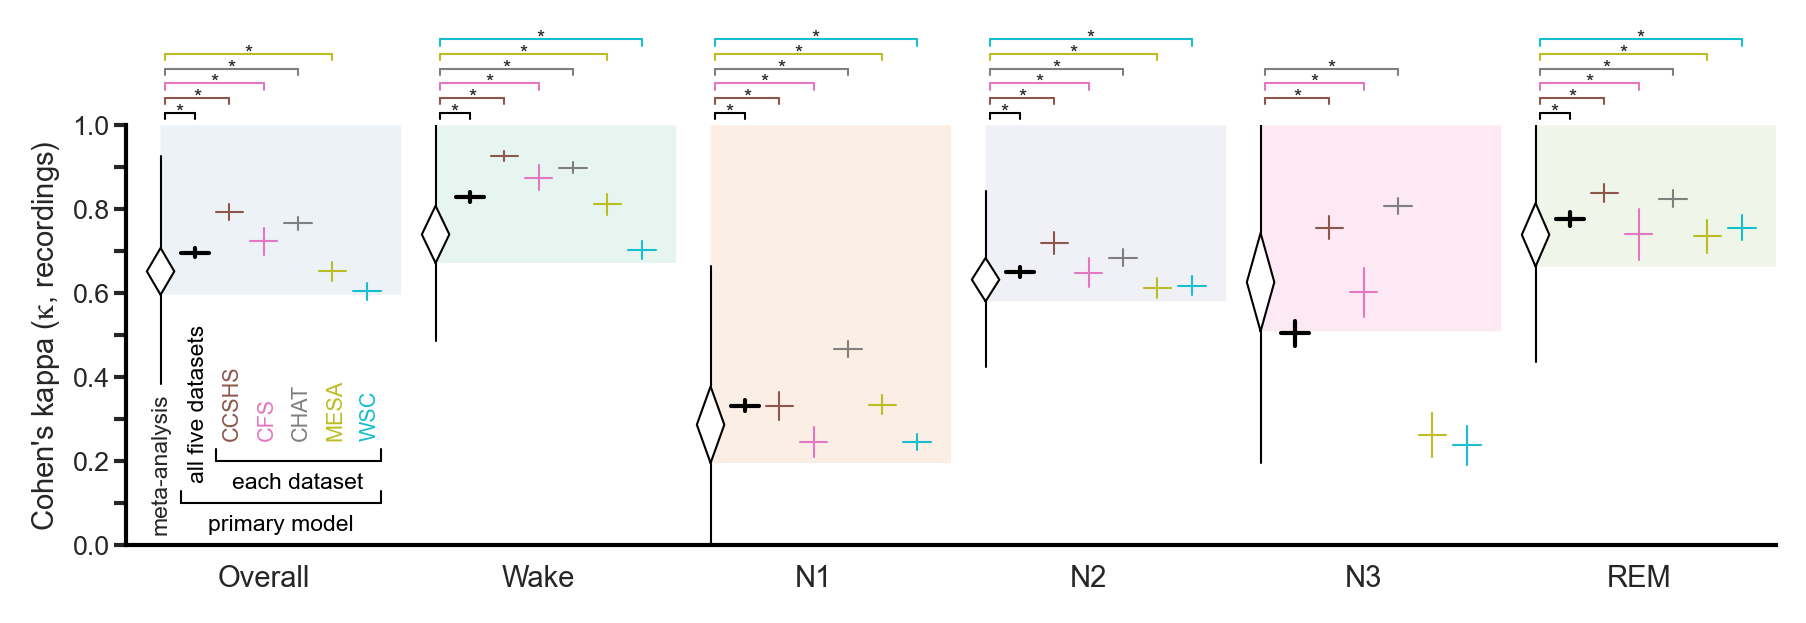

In [13]:

ax = sns.lineplot()

for i, stage in enumerate(stages):
    print(stage)
    plot_meta_and_ours_transposed(ax, stage, i)

    ## add sig bar
    if i == 0:
        for j in range(5):
            add_stat_horiz(ax, 1.02+0.01 + j*0.035, i+1/8+0.015, i+(j+2)/8, "*", 0, color=study_palette[j])
    elif i == 4:
        for j in [1,2,3]:
            add_stat_horiz(ax, 1.02+0.01 + j*0.035, i+1/8+0.015, i+(j+2)/8, "*", 0, color=study_palette[j])
    else:
        for j in range(6):
            add_stat_horiz(ax, 1.02+0.01 + j*0.035, i+1/8+0.015, i+(j+2)/8, "*", 0, color=study_palette[j])




sns.despine(ax=ax, right=True, top=True, bottom=False)
ax.grid(False)
ax.tick_params(axis="y", left=True, width=1, length=3, pad=1)
ax.tick_params(axis="x", bottom=True, width=1, length=3, pad=1)

ax.set_ylim([0, 1])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
for label in ax.get_yticklabels()[1::2]:
    label.set_visible(False)

ax.set_xlim([0, 6])
ax.tick_params(axis='x', bottom=False, width=1, length=3, pad=1)
for label in ax.get_xticklabels():
    label.set_visible(False)

labelpad = 2.5
ax.set_ylabel(
    "Cohen's kappa ($\kappa$, recordings)", fontweight=None, labelpad=labelpad
)

## add notes for datasets breakout
ax.text(
        (4.5/8)/6,
        0.05,
        "primary model",
        transform=ax.transAxes,
        fontsize=5.5,
        color="black",
        va="center",
        ha="center",
)
ax.axhline(
        y=0.1,
        xmin=(1.6/8)/6,
        xmax=(7.4/8)/6,
        color="black",
        linewidth=0.5,
        linestyle="-",
        clip_on=False
    )
ax.axvline(
        x=(1.6/8),
        ymin=0.1,
        ymax=0.13,
        color="black",
        linewidth=0.5,
        linestyle="-",
        clip_on=False
    )
ax.axvline(
        x=(7.4/8),
        ymin=0.1,
        ymax=0.13,
        color="black",
        linewidth=0.5,
        linestyle="-",
        clip_on=False
    )

ax.text(
        (5/8)/6,
        0.15,
        "each dataset",
        transform=ax.transAxes,
        fontsize=5.5,
        color="black",
        va="center",
        ha="center",
    )
ax.axhline(
        y=0.2,
        xmin=(2.6/8)/6,
        xmax=(7.4/8)/6,
        color="black",
        linewidth=0.5,
        linestyle="-",
        clip_on=False
    )
ax.axvline(
        x=(2.6/8),
        ymin=0.2,
        ymax=0.23,
        color="black",
        linewidth=0.5,
        linestyle="-",
        clip_on=False
    )
ax.axvline(
        x=(7.4/8),
        ymin=0.20,
        ymax=0.23,
        color="black",
        linewidth=0.5,
        linestyle="-",
        clip_on=False
    )


plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
figure_standard.scale_figure_by_axes(ax, 1.4, 5.5)

# save the figure
filename = "figure_6"
figure_standard.save_figure_files(filename)

In [14]:
## real-time model comparison

dx = 1/(4)
width_ratio = 0.4

def plot_meta_and_ours_transposed_rt(axes, stage, offset):
    # plotting the results transposed (vertically, instead of horizontally)
    # and this function will plot just the necessary results


    ## meta result
    x = offset + dx
    mean_k = df_meta_results.loc[df_meta_results.stage == stage, "mean"].values[0]

    lower_ci = df_meta_results.loc[df_meta_results.stage == stage, "lci"].values[0]
    upper_ci = df_meta_results.loc[df_meta_results.stage == stage, "uci"].values[0]

    y_array = [lower_ci, mean_k, upper_ci, mean_k, lower_ci]
    x_array = [x, x + dx*width_ratio , x, x - dx*width_ratio , x]
    sns.lineplot(
        x=x_array,
        y=y_array,
        color=meta_color,
        linewidth=ci_linewidth,
        estimator=None,
        sort=False,
        ax=axes,
    )

    lower_pi = df_meta_results.loc[df_meta_results.stage == stage, "lpi"].values[0]
    upper_pi = df_meta_results.loc[df_meta_results.stage == stage, "upi"].values[0]
    axes.axvline(
        x=x,
        ymin=lower_pi,
        ymax=lower_ci,
        color=meta_color,
        linewidth=ci_linewidth,
    )
    axes.axvline(
        x=x,
        ymin=upper_ci,
        ymax=upper_pi,
        color=meta_color,
        linewidth=ci_linewidth,
    )

    if preserved_fraction < 1:
        fill_y = [lower_ci * preserved_fraction, lower_ci, mean_k, upper_ci, 1]
        fill_x = [x, x, x + dx*width_ratio, x, x]
    else:
        fill_y = [lower_ci, mean_k, upper_ci, 1]
        fill_x = [x, x + dx*width_ratio, x, x]
    fill_x_l = [x+1-dx*1] * len(fill_x)

    axes.fill_betweenx(
        fill_y,
        fill_x,
        fill_x_l,
        color=main_palette[offset],
        alpha=0.1,
        edgecolor="none",
    )

    if offset == 0:
        axes.text(
            x/6,
            0.025,
            "meta-analysis",
            transform=axes.transAxes,
            fontsize=5.5,
            va="bottom",
            ha="center",
        ).set_rotation(90)


    ## our result
    for i, study in enumerate(studies):
        x = offset + (dx)*(i+2)
        # study = 'all'
        mean_k = df_meta_results.loc[
            df_meta_results.stage == stage, (study.lower() + "_mean")
        ].values[0]
        lower_ci = df_meta_results.loc[
            df_meta_results.stage == stage, (study.lower() + "_lci")
        ].values[0]
        upper_ci = df_meta_results.loc[
            df_meta_results.stage == stage, (study.lower() + "_uci")
        ].values[0]

        study_color = study_palette[i]
        if i == 0:
            width_scale = 2
        else:
            width_scale = 1

        sns.lineplot(
            x=[x - dx*width_ratio, x + dx*width_ratio],
            y=[mean_k, mean_k],
            color=study_color,
            linewidth=ci_linewidth*width_scale,
            estimator=None,
            sort=False,
            ax=axes,
        )
        axes.axvline(
            x=x,
            ymin=lower_ci,
            ymax=upper_ci,
            color=study_color,
            linewidth=ci_linewidth*width_scale,
            linestyle="-",
        )

        if offset == 0:
            label_text = study
            label_size = 5.2
            color = study_color
            axis_offset = 0.25
            if i == 0:
                label_text = "primary model"
                label_size = 5.5
                color = 'black'
                axis_offset = 0.025

            axes.text(
                x/6 + 0.01/6,
                axis_offset,
                label_text,
                transform=axes.transAxes,
                fontsize=label_size,
                color=color,
                va="bottom",
                ha="center",
            ).set_rotation(90)
        break


    # rt result here
    width_scale = 1
    x = offset + (dx)*(1+2)
    mean_k = df_meta_results.loc[
        df_meta_results.stage == stage, ("rt_all_mean")
    ].values[0]
    lower_ci = df_meta_results.loc[
        df_meta_results.stage == stage, ("rt_all_lci")
    ].values[0]
    upper_ci = df_meta_results.loc[
        df_meta_results.stage == stage, ("rt_all_uci")
    ].values[0]

    sns.lineplot(
        x=[x - dx*width_ratio, x + dx*width_ratio],
        y=[mean_k, mean_k],
        color="red",
        linewidth=ci_linewidth*width_scale,
        estimator=None,
        sort=False,
        ax=axes,
    )
    axes.axvline(
        x=x,
        ymin=lower_ci,
        ymax=upper_ci,
        color="red",
        linewidth=ci_linewidth*width_scale,
        linestyle="-",
    )
    if offset==0:
        label_text = "real-time model"
        axis_offset = 0.025
        label_size = 5.5
        color = "black"
        axes.text(
            x/6 + 0.01/6,
            axis_offset,
            label_text,
            transform=axes.transAxes,
            fontsize=label_size,
            color="red",
            va="bottom",
            ha="center",
        ).set_rotation(90)


    axis_label = stage
    if offset == 0:
        axis_label = "Overall"
    axes.text(
        (offset+0.5- 0.005)/6,
        -0.08,
        axis_label,
        transform=axes.transAxes,
        fontsize=7,
        va="center",
        ha="center",
    )

All
Wake
N1
N2
N3
REM


1 extra bytes in post.stringData array
fdsc NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
just NOT subset; don't know how to subset; dropped


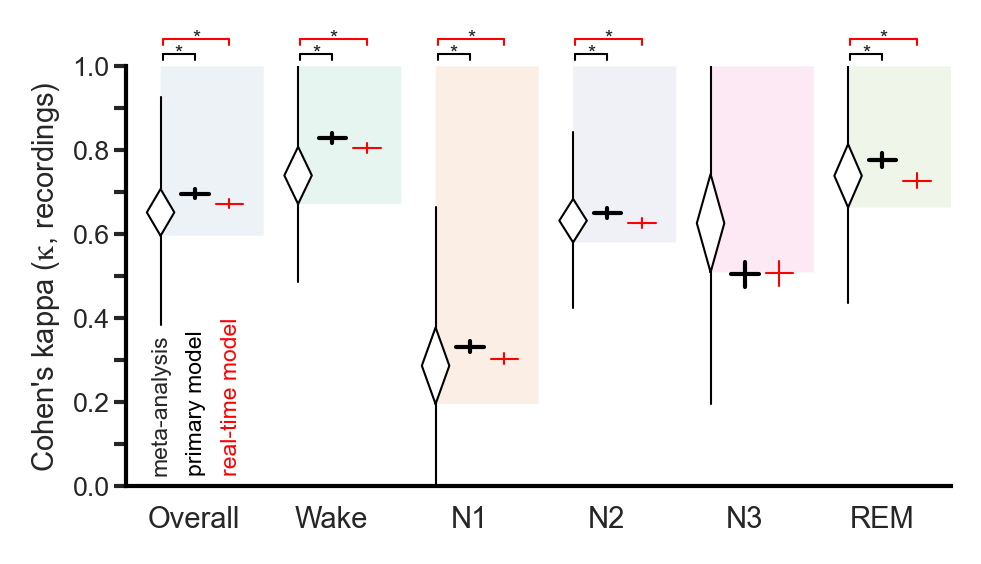

In [15]:
ax = sns.lineplot()

for i, stage in enumerate(stages):
    print(stage)
    plot_meta_and_ours_transposed_rt(ax, stage, i)

    ## add sig bar
    if i != 4:
        for j in range(2):
            color = 'black'
            if j == 1:
                color = 'red'
            add_stat_horiz(ax, 1.02+0.01 + j*0.035, i+1/4+0.015, i+(j+2)/4, "*", 0, color=color)


sns.despine(ax=ax, right=True, top=True, bottom=False)
ax.grid(False)
ax.tick_params(axis="y", left=True, width=1, length=3, pad=1)
ax.tick_params(axis="x", bottom=True, width=1, length=3, pad=1)

ax.set_ylim([0, 1])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
for label in ax.get_yticklabels()[1::2]:
    label.set_visible(False)

ax.set_xlim([0, 6])
ax.tick_params(axis='x', bottom=False, width=1, length=3, pad=1)
for label in ax.get_xticklabels():
    label.set_visible(False)

labelpad = 2.5
ax.set_ylabel(
    "Cohen's kappa ($\kappa$, recordings)", fontweight=None, labelpad=labelpad
)


plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
figure_standard.scale_figure_by_axes(ax, 1.4, 5.5/8*4)

# save the figure
filename = "figure_11"
figure_standard.save_figure_files(filename)